# Classifying 40 different types of leaf speciies

In [1]:
# Load the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import random
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [10]:
!unzip "leaves.zip"

Archive:  leaves.zip
replace leaves/Acca sellowiana/iPAD2_C32_EX01.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX01.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX02.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX03.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX04.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX05.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX06.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX07.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX08.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX09.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX10.JPG  
  inflating: leaves/Acca sellowiana/iPAD2_C32_EX11.JPG  
  inflating: leaves/Acer negundo/iPAD2_C16_EX01.JPG  
  inflating: leaves/Acer negundo/iPAD2_C16_EX02.JPG  
  inflating: leaves/Acer negundo/iPAD2_C16_EX03.JPG  
  inflating: leaves/Acer negundo/iPAD2_C16_EX04.JPG  
  inflating: leaves/Acer negundo/iPAD2_C16_EX

In [0]:
def load_images_from_folder(folder,only_path = False, label = ""):
# Load the paths to the images in a directory
# or load the images
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [12]:
# Load the paths on the images
images = []
dirp = "leaves/"
for f in os.listdir(dirp):
    if "JPG" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
            
# Create a dataframe with the paths and the label for each fruit
df = pd.DataFrame(images, columns = ["leaf", "path"])

# Shuffle the dataset
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

# Assign to each fruit a specific number
leaf_names = sorted(df.leaf.unique())
mapper_leaf_names = dict(zip(leaf_names, [t for t in range(len(leaf_names))]))
df["label"] = df["leaf"].map(mapper_leaf_names)
print(mapper_leaf_names)

# Visualize the resulting dataframe
df.head()

{'Acca sellowiana': 0, 'Acer negundo': 1, 'Acer palmaturu': 2, 'Aesculus californica': 3, 'Alnus sp': 4, 'Arisarum vulgare': 5, 'Betula pubescens': 6, 'Bougainvillea sp': 7, 'Buxus sempervirens': 8, 'Castanea sativa': 9, 'Celtis sp': 10, 'Chelidonium majus': 11, 'Corylus avellana': 12, 'Crataegus monogyna': 13, 'Erodium sp': 14, 'Euonymus japonicus': 15, 'Fragaria vesca': 16, 'Fraxinus sp': 17, 'Geranium sp': 18, 'Hydrangea sp': 19, 'Ilex aquifolium': 20, 'Ilex perado ssp azorica': 21, 'Magnolia grandiflora': 22, 'Magnolia soulangeana': 23, 'Nerium oleander': 24, 'Papaver sp': 25, 'Pinus sp': 26, 'Podocarpus sp': 27, 'Polypodium vulgare': 28, 'Populus alba': 29, 'Populus nigra': 30, 'Primula vulgaris': 31, 'Pseudosasa japonica': 32, 'Quercus robur': 33, 'Quercus suber': 34, 'Salix atrocinerea': 35, 'Schinus terebinthifolius': 36, 'Taxus bacatta': 37, 'Tilia tomentosa': 38, 'Urtica dioica': 39}


,leaf,path,label
0,Urtica dioica,leaves/Urtica dioica/iPAD2_C30_EX12.JPG,39
1,Betula pubescens,leaves/Betula pubescens/iPAD2_C09_EX04.JPG,6
2,Celtis sp,leaves/Celtis sp/iPAD2_C12_EX03.JPG,10
3,Magnolia soulangeana,leaves/Magnolia soulangeana/iPAD2_C28_EX01.JPG,23
4,Acer negundo,leaves/Acer negundo/iPAD2_C16_EX02.JPG,1


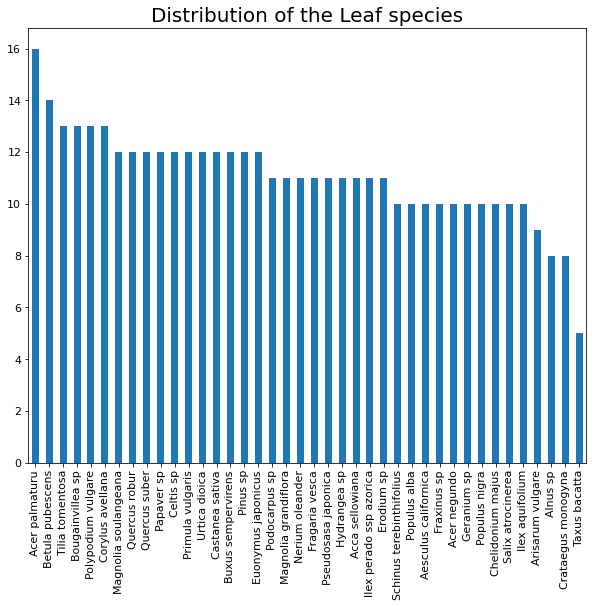

In [13]:
bar = df["leaf"].value_counts().plot.bar(figsize = (10,8))
plt.title("Distribution of the Leaf species", fontsize = 20)
bar.tick_params(labelsize=11)
plt.show()

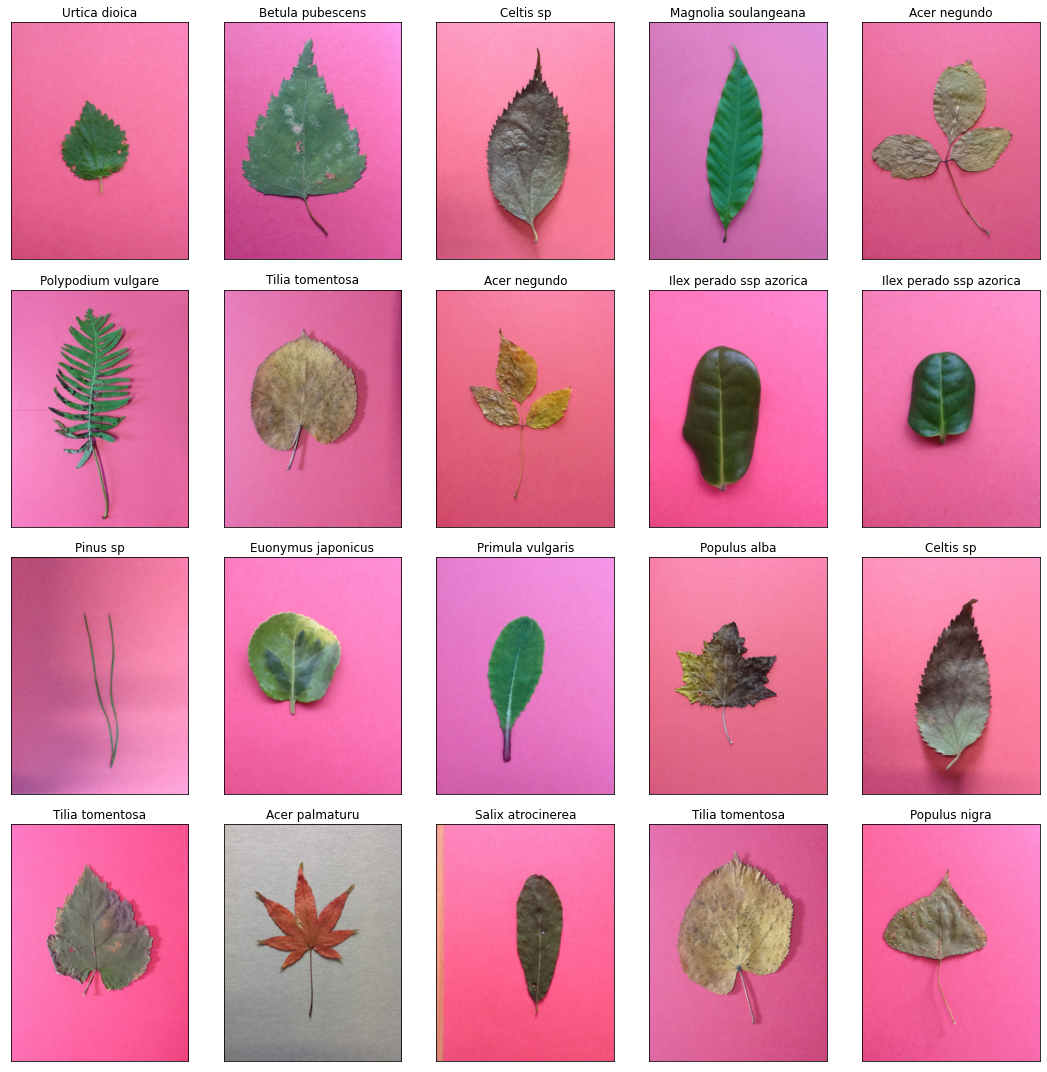

In [14]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i]))
    ax.set_title(df.leaf[i])
plt.tight_layout()
plt.show()

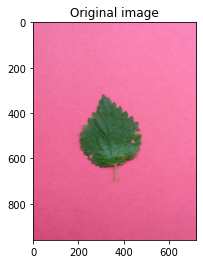

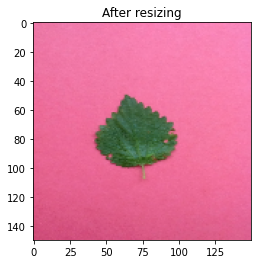

In [15]:
# The pictures will be resized to have the same size for the neural network
img = plt.imread(df.path[0])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

# Create and train the CNN Model with Keras

In [0]:
def cut_df(df, number_of_parts, part):
# Return a part of the dataframe
# For example, if a dataframe has 10 rows and we want to return a part of them
# if it is cut in two, it will return the first 5 rows or the last 5 rows depending the part wanted

# Args:
#     df (pandas.DataFrame): The dataframe to cut a part of
#     number_of_parts (int): In how many parts should the dataframe be cut
#     part (int): The part of the dataframe to return

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]

def load_img(df):
# Load the images using their contained in the dataframe df
# Return a list of images and a list with the labels of the images
    img_paths = df["path"].values
    img_labels = df["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [0]:


def create_model():
    shape_img = (150,150,3)
    
    model = Sequential()

    model.add(ResNet50(
        include_top=False,
        pooling='avg',
        weights='imagenet',
        ))

    num_classes = 40
    model.add(Dense(num_classes, activation='softmax'))
    #model.layers
    model.layers[0].trainable = False
    model.summary() 

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [0]:
def from_categorical(lst):
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
# Display prediction statistics
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\nAccuracy:", round(accuracy_score(y_test_class, pred),5))
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [21]:
model = create_model()
hists = []

# The model will be trained with 1/5 of the data
for i in range(1,2):
    start_time = time.time()
    X_train, y_train = load_img(cut_df(df, 5, i))
    y_train = to_categorical(y_train)

    callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='leaves_model_5e.h5', monitor='val_loss', save_best_only=True)]
    
    model.fit(X_train, y_train, batch_size=5, epochs=10, callbacks=callbacks, validation_split = 0.2, verbose = 1)
    hists.append(model.history.history)
    
    # Delete X_train and y_train to avoid using too much RAM
    del X_train
    del y_train

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 40)                81960     
Total params: 23,669,672
Trainable params: 81,960
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10
14/14 [==============================] - 1s 98ms/step - loss: 4.8577 - accuracy: 0.1286 - val_loss: 4.4621 - val_accuracy: 0.2222
Epoch 2/10
14/14 [==============================] - 0s 17ms/step - loss: 1.7574 - accuracy: 0.5429 - val_loss: 4.4959 - val_accuracy: 0.2778
Epoch 3/10
14/14 [==============================] - 3s 189ms/step - loss: 0.6837 - accuracy: 0.9429 - val_loss: 4.0131 - val_accuracy: 0.4444
Epoch 4/10
14/14 [==============================] - 3s 211ms/step - loss: 0

In [22]:
time_model = time.time() - start_time
print(f"Time to load the pictures and to train the model: {int(time_model)} seconds")

Time to load the pictures and to train the model: 47 seconds


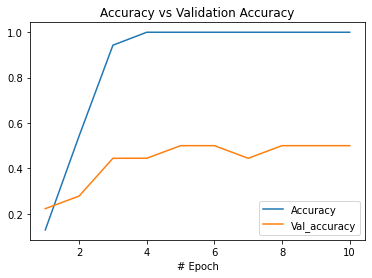

In [23]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

# Predictions

In [29]:
# Make predictions with the model using the last 1/20 part of the dataset
X, y = load_img(cut_df(df, 20, 2))
pred = model.predict_classes(X)
y_test = to_categorical(y)

# Display statistics
display_stats(y_test, pred)

### Result of the predictions using 22 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          19       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         1
          22       1.00      1.00      1.00         2
          23       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         2
          28       1.00      1.00      1.00         1
          30       1.00      1.00      1.00         1
   

# Visualize the result with pictures of leaves

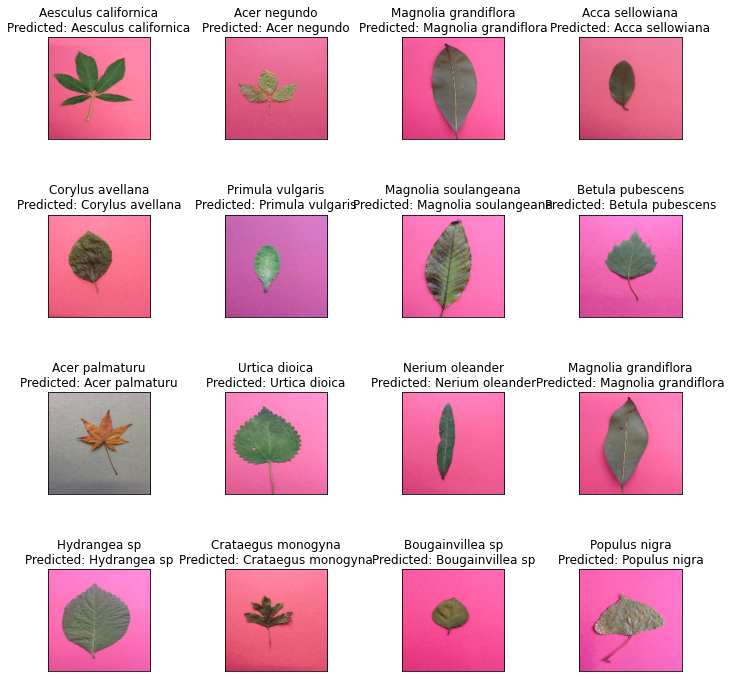

Percentage correct: 100.0%


In [31]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

total_correct = 0
for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"{leaf_names[y[-i]]}\nPredicted: {leaf_names[pred[-i]]}")
    if leaf_names[y[-i]] == leaf_names[pred[-i]]:
        total_correct = total_correct + 1

plt.tight_layout()
plt.show()

print("Percentage correct: {}%".format((total_correct / len(axes.flat))*100))